In [1]:
!pip -q install transformers datasets

!pip -q install evaluate



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00


In [1]:

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
class TextCleaner():
    def __init__(self):
        pass

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"\'scuse", " excuse ", text)
        text = re.sub('\W', ' ', text)
        text = re.sub('\s+', ' ', text)
        text = text.strip(' ')

        return text

cleaner = TextCleaner()


In [ ]:
# Cargamos el dataset y nos quedamos con las columnas relevantes
file_path = 'youtoxic_english_1000.csv'
df = pd.read_csv(file_path)

df = df[['Text', 'IsToxic']]
df['IsToxic'] = df['IsToxic'].astype(int)
df['Text'] = df['Text'].apply(cleaner.clean_text)

In [ ]:
from transformers import  AutoModelForSequenceClassification, AutoTokenizer

checkpoint = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli" # Modelo sobre el que realizaremos fine tuning
classifier = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, ignore_mismatched_sizes=True) # Declaración del classifier
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # tokenizer



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df_train, df_eval = train_test_split(df, train_size=0.8, random_state=42) 

In [5]:
df_train.head()

,Text,IsToxic
29,there is blood on the street but you are worri...,0
535,i do not really care to much for some cops but...,1
695,those dumb fucks screwing fellow citizens over...,1
557,non lethal weapon do not control crowds lol i ...,1
836,yea we should beat up all white people rob bla...,1


In [6]:
from datasets import Dataset, DatasetDict
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "eval": Dataset.from_pandas(df_eval)
})

In [ ]:
# Comprobación de datasets
print("Dataset Dict:\n", raw_datasets)
print("\n\nTrain's features:\n", raw_datasets["train"].features)
print("\n\nFirst row of Train:\n", raw_datasets["train"][0])

Dataset Dict:
 DatasetDict({
    train: Dataset({
        features: ['Text', 'IsToxic', '__index_level_0__'],
        num_rows: 800
    })
    eval: Dataset({
        features: ['Text', 'IsToxic', '__index_level_0__'],
        num_rows: 200
    })
})


Train's features:
 {'Text': Value(dtype='string', id=None), 'IsToxic': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


First row of Train:
 {'Text': 'there is blood on the street but you are worried about words we are all getting very tired with the way mainstream media is treating us like idiots who will follow their condescending irrelevant distracting disparaging narrative step up cnn', 'IsToxic': 0, '__index_level_0__': 29}


In [ ]:


# Tokenizamos el texto, truncando si excede la longitud máxima
tokenized_datasets = raw_datasets.map(lambda dataset: tokenizer(dataset['Text'], truncation=True), batched=True)
print(tokenized_datasets)



Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Text', 'IsToxic', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 800
    })
    eval: Dataset({
        features: ['Text', 'IsToxic', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [11]:
print(tokenized_datasets["train"][0])

{'Text': 'there is blood on the street but you are worried about words we are all getting very tired with the way mainstream media is treating us like idiots who will follow their condescending irrelevant distracting disparaging narrative step up cnn', 'IsToxic': 0, '__index_level_0__': 29, 'input_ids': [1, 343, 269, 1452, 277, 262, 2011, 304, 274, 281, 4515, 314, 1023, 301, 281, 305, 646, 379, 4111, 275, 262, 384, 6479, 806, 269, 6394, 381, 334, 26878, 328, 296, 1111, 308, 48509, 13383, 22962, 59557, 5273, 1095, 322, 2285, 16301, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
tokenized_datasets = tokenized_datasets.remove_columns(["Text", "__index_level_0__"])
tokenized_datasets = tokenized_datasets.rename_column("IsToxic", "labels")
print(tokenized_datasets)



DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 800
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [ ]:
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import numpy as np
import evaluate

# Padding del batch de datos
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training args
training_args = TrainingArguments("test-trainer", num_train_epochs=1, evaluation_strategy="epoch",
                                  weight_decay=5e-4, save_strategy="no", report_to="none")



# Almacenar las últimas accuracies
latest_train_accuracy = None
latest_val_accuracy = None

def compute_metrics(eval_preds):
    global latest_train_accuracy, latest_val_accuracy

    metric = evaluate.load("glue", "mrpc")  # F1 and Accuracy
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Cálculo de F1 y Accuracy
    results = metric.compute(predictions=predictions, references=labels)

   
    if latest_train_accuracy is None:
        latest_train_accuracy = results['accuracy']
    else:
        latest_val_accuracy = results['accuracy']

    # overfitting score
    if latest_val_accuracy is not None:
        overfitting_score = latest_train_accuracy - latest_val_accuracy
    else:
        overfitting_score = 0  # Sin datos suficientes para determinar overfitting


    results['overfitting_score'] = overfitting_score

    return results



# Definimos el trainer
trainer = Trainer(
    classifier,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



In [ ]:
# Realizamos el fine tuning
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Overfitting Score
1,No log,0.422533,0.820000,0.818182,0


TrainOutput(global_step=100, training_loss=0.5915171051025391, metrics={'train_runtime': 32.8691, 'train_samples_per_second': 24.339, 'train_steps_per_second': 3.042, 'total_flos': 45584807837184.0, 'train_loss': 0.5915171051025391, 'epoch': 1.0})

In [ ]:
from sklearn.metrics import classification_report


y_pred = trainer.predict(tokenized_datasets["eval"]).predictions
y_pred = np.argmax(y_pred, axis=-1)

# Obtener true labels
y_true = tokenized_datasets["eval"]["labels"]
y_true = np.array(y_true)

# classification report
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.761     0.892     0.822        93
           1      0.890     0.757     0.818       107

    accuracy                          0.820       200
   macro avg      0.826     0.825     0.820       200
weighted avg      0.830     0.820     0.820       200




Overfitting Analysis:
Training Accuracy: 0.8500
Evaluation Accuracy: 0.8200
Accuracy Difference (Train - Eval): 0.0300


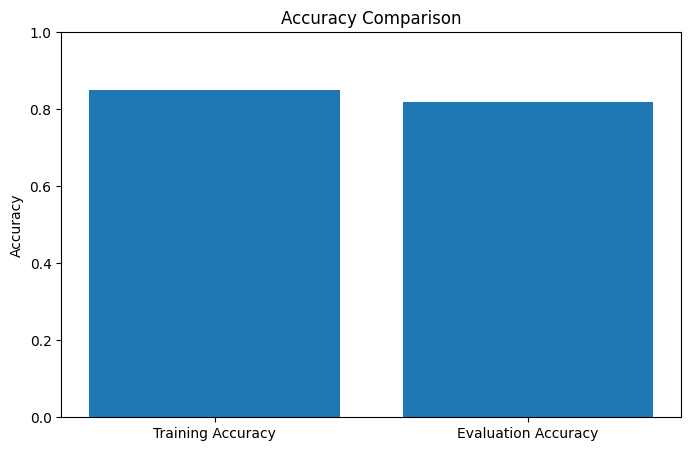

In [ ]:
# Cálculo Overfitting
def evaluate_overfitting():
    # Predicción del  training dataset
    train_preds = trainer.predict(tokenized_datasets["train"]).predictions
    train_preds = np.argmax(train_preds, axis=-1)
    train_labels = tokenized_datasets["train"]["labels"]
    train_labels = np.array(train_labels)

    # Predicción del  evaluation dataset
    eval_preds = trainer.predict(tokenized_datasets["eval"]).predictions
    eval_preds = np.argmax(eval_preds, axis=-1)
    eval_labels = tokenized_datasets["eval"]["labels"]
    eval_labels = np.array(eval_labels)

   
    train_accuracy = accuracy_score(train_labels, train_preds)
    eval_accuracy = accuracy_score(eval_labels, eval_preds)

    # overfitting analysis
    print("\nOverfitting Analysis:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Evaluation Accuracy: {eval_accuracy:.4f}")
    print(f"Accuracy Difference (Train - Eval): {train_accuracy - eval_accuracy:.4f}")

   
    plt.figure(figsize=(8, 5))
    plt.bar(['Training Accuracy', 'Evaluation Accuracy'], [train_accuracy, eval_accuracy])
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

# Call the overfitting check function after training
evaluate_overfitting()

In [ ]:
# Directory to save the model
model_dir = "model"

# Save the model
classifier.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/spm.model',
 'model/added_tokens.json',
 'model/tokenizer.json')